# SVD를 활용한 웹소설 제목과 조회수의 연관성 분석

## 프로젝트 개요
이 노트북은 **특이값 분해(SVD, Singular Value Decomposition)**를 활용하여 문피아 웹소설의 제목과 조회수 간의 연관성을 분석합니다.

### 분석 목표
- 웹소설 제목에서 추출한 키워드와 조회수 간의 상관관계 분석
- SVD를 통한 차원 축소 및 잠재 요인 발견
- 조회수에 영향을 주는 제목 패턴 식별

### 분석 방법론
1. 텍스트 전처리 및 TF-IDF 벡터화
2. SVD를 통한 차원 축소
3. 잠재 요인과 조회수의 상관관계 분석
4. 결과 시각화 및 해석

## 1. 실험 환경 정보

In [4]:
import sys
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import sklearn
import scipy
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

print("=== 실험 환경 정보 ===")
print(f"Python 버전: {sys.version}")
print(f"운영체제: {platform.system()} {platform.release()}")
print(f"플랫폼: {platform.platform()}")
print("\n=== 주요 라이브러리 버전 ===")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"scipy: {scipy.__version__}")

=== 실험 환경 정보 ===
Python 버전: 3.7.8 (tags/v3.7.8:4b47a5b6ba, Jun 28 2020, 08:53:46) [MSC v.1916 64 bit (AMD64)]
운영체제: Windows 10
플랫폼: Windows-10-10.0.26100-SP0

=== 주요 라이브러리 버전 ===
pandas: 1.3.5
numpy: 1.21.6
matplotlib: 3.5.3
seaborn: 0.12.2
scikit-learn: 1.0.2
scipy: 1.7.3


## 2. 데이터 파일 설명

### 데이터 소스
본 분석에서 사용하는 데이터는 **문피아(Munpia) 콘테스트 랭킹** 데이터입니다.

### 파일 구조
```
munpia/data/
├── munpia_contest_ranking_20250605_225739.csv
├── munpia_contest_ranking_20250606_192421.csv
├── munpia_contest_ranking_20250607_132239.csv
├── munpia_contest_ranking_20250609_192234.csv
├── munpia_contest_ranking_20250610_222536.csv
├── munpia_contest_ranking_20250611_215656.csv
└── munpia_contest_ranking_20250612_200038.csv
```

### 데이터 컬럼 설명
| 컬럼명 | 설명 | 데이터 타입 |
|--------|------|-------------|
| `crawl_rank` | 크롤링 순서 | int |
| `novel_url` | 소설 URL | string |
| `novel_id` | 소설 고유 ID | int |
| `rank_number` | 랭킹 순위 | int |
| `author` | 작가명 | string |
| `title` | **소설 제목** (분석 대상) | string |
| `genre` | 장르 | string |
| `view_count` | 조회수 (문자열) | string |
| `view_count_number` | **조회수 (숫자)** (분석 대상) | int |
| `rank_change` | 순위 변동 | string |
| `rank_change_number` | 순위 변동 (숫자) | int |
| `reading_rate` | 독서율 (문자열) | string |
| `reading_rate_number` | 독서율 (숫자) | float |

### 분석 대상 필드
- **주요 분석 필드**: `title` (제목), `view_count_number` (조회수)
- **보조 분석 필드**: `genre` (장르), `reading_rate_number` (독서율)

## 3. 데이터 로딩 및 전처리

In [12]:
import glob
import os

# 데이터 파일 경로 설정 (현재 폴더 기준 상대경로)
data_path = r'munpia\data\*.csv'
csv_files = glob.glob(data_path)

print(f"발견된 CSV 파일 수: {len(csv_files)}")
for file in csv_files:
    print(f"- {os.path.basename(file)}")

# 모든 CSV 파일을 하나의 DataFrame으로 결합
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='utf-8')
        df['file_date'] = os.path.basename(file).split('_')[3].split('.')[0]  # 날짜 추출
        dataframes.append(df)
        print(f"✓ {os.path.basename(file)}: {len(df)} 행")
    except Exception as e:
        print(f"✗ {os.path.basename(file)}: 오류 - {e}")

# DataFrame 결합
df_combined = pd.concat(dataframes, ignore_index=True)
print(f"\n전체 데이터: {len(df_combined)} 행, {len(df_combined.columns)} 열")

발견된 CSV 파일 수: 7
- munpia_contest_ranking_20250605_225739.csv
- munpia_contest_ranking_20250606_192421.csv
- munpia_contest_ranking_20250607_132239.csv
- munpia_contest_ranking_20250609_192234.csv
- munpia_contest_ranking_20250610_222536.csv
- munpia_contest_ranking_20250611_215656.csv
- munpia_contest_ranking_20250612_200038.csv
✓ munpia_contest_ranking_20250605_225739.csv: 200 행
✓ munpia_contest_ranking_20250606_192421.csv: 200 행
✓ munpia_contest_ranking_20250607_132239.csv: 200 행
✓ munpia_contest_ranking_20250609_192234.csv: 200 행
✓ munpia_contest_ranking_20250610_222536.csv: 200 행
✓ munpia_contest_ranking_20250611_215656.csv: 200 행
✓ munpia_contest_ranking_20250612_200038.csv: 200 행

전체 데이터: 1400 행, 14 열


In [13]:
# 데이터 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(df_combined.info())
print("\n=== 처음 5행 ===")
print(df_combined.head())
print("\n=== 기본 통계 ===")
print(df_combined.describe())

=== 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   crawl_rank           1400 non-null   int64  
 1   novel_url            1400 non-null   object 
 2   novel_id             1400 non-null   int64  
 3   rank_number          1400 non-null   int64  
 4   author               1400 non-null   object 
 5   title                1400 non-null   object 
 6   genre                1400 non-null   object 
 7   view_count           1400 non-null   object 
 8   view_count_number    1400 non-null   int64  
 9   rank_change          1400 non-null   object 
 10  rank_change_number   1392 non-null   float64
 11  reading_rate         1400 non-null   object 
 12  reading_rate_number  1122 non-null   float64
 13  file_date            1400 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 153.2+ KB
None

=== 처

In [15]:
# 데이터 전처리
# 1. 중복 제거 (novel_id 기준으로 최신 데이터만 유지)
df_clean = df_combined.sort_values('file_date').drop_duplicates(subset=['novel_id'], keep='last')

# 2. 필요한 컬럼만 선택
columns_needed = ['novel_id', 'title', 'author', 'genre', 'view_count_number', 'reading_rate_number']
df_analysis = df_clean[columns_needed].copy()

# 3. 결측치 처리
print("=== 결측치 확인 ===")
print(df_analysis.isnull().sum())

# 제목이나 조회수가 없는 데이터 제거
df_analysis = df_analysis.dropna(subset=['title', 'view_count_number'])

# 4. 데이터 타입 확인 및 변환
df_analysis['view_count_number'] = pd.to_numeric(df_analysis['view_count_number'], errors='coerce')
df_analysis = df_analysis.dropna(subset=['view_count_number'])

print(f"\n전처리 후 데이터: {len(df_analysis)} 행")
print(f"조회수 범위: {df_analysis['view_count_number'].min():,} ~ {df_analysis['view_count_number'].max():,}")

=== 결측치 확인 ===
novel_id                0
title                   0
author                  0
genre                   0
view_count_number       0
reading_rate_number    50
dtype: int64

전처리 후 데이터: 267 행
조회수 범위: 43 ~ 14,485


## 4. 텍스트 전처리 및 벡터화

In [18]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def preprocess_title(title):
    """제목 전처리 함수"""
    # 특수문자 제거 (한글, 영문, 숫자만 유지)
    title = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', title)
    # 연속된 공백 제거
    title = re.sub(r'\s+', ' ', title).strip()
    return title

def extract_keywords_simple(title):
    """간단한 키워드 추출 (형태소 분석 없이)"""
    try:
        # 전처리
        cleaned_title = preprocess_title(title)
        # 공백으로 분리하여 2글자 이상의 단어만 유지
        words = cleaned_title.split()
        keywords = [word for word in words if len(word) >= 2]
        return ' '.join(keywords)
    except:
        return preprocess_title(title)

# 제목에서 키워드 추출 (Java/konlpy 없이 간단한 방법 사용)
print("제목에서 키워드 추출 중...")
print("※ 참고: Java가 설치되지 않아 konlpy 대신 간단한 텍스트 분할 방법을 사용합니다.")
df_analysis['title_keywords'] = df_analysis['title'].apply(extract_keywords_simple)

# 예시 출력
print("\n=== 키워드 추출 예시 ===")
for i in range(5):
    print(f"원본: {df_analysis.iloc[i]['title']}")
    print(f"키워드: {df_analysis.iloc[i]['title_keywords']}")
    print()

제목에서 키워드 추출 중...
※ 참고: Java가 설치되지 않아 konlpy 대신 간단한 텍스트 분할 방법을 사용합니다.

=== 키워드 추출 예시 ===
원본: 천재 개발자가 미래기술을 숨김
키워드: 천재 개발자가 미래기술을 숨김

원본: 백년전쟁 속 병사로 살아남기
키워드: 백년전쟁 병사로 살아남기

원본: 엘프녀랑 재혼했더니 인생이 너무 쉬움
키워드: 엘프녀랑 재혼했더니 인생이 너무 쉬움

원본: 퇴사 후 인생 역전
키워드: 퇴사 인생 역전

원본: 귀환하니까 내 업적이 너무 대단하다
키워드: 귀환하니까 업적이 너무 대단하다



In [20]:
# TF-IDF 벡터화
print("TF-IDF 벡터화 수행 중...")

# 빈 키워드 제거
df_analysis = df_analysis[df_analysis['title_keywords'].str.len() > 0]

# TF-IDF 벡터라이저 설정
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # 최대 1000개 특성
    min_df=2,          # 최소 2개 문서에서 나타나는 단어
    max_df=0.8,        # 80% 이상 문서에서 나타나는 단어 제외
    ngram_range=(1, 2) # 1-gram과 2-gram 사용
)

# TF-IDF 행렬 생성
tfidf_matrix = tfidf_vectorizer.fit_transform(df_analysis['title_keywords'])

print(f"TF-IDF 행렬 크기: {tfidf_matrix.shape}")
print(f"특성(단어) 수: {len(tfidf_vectorizer.get_feature_names_out())}")

# 상위 키워드 확인
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n상위 20개 키워드: {list(feature_names[:20])}")

TF-IDF 벡터화 수행 중...
TF-IDF 행렬 크기: (267, 104)
특성(단어) 수: 104

상위 20개 키워드: ['s급', 'the', '각성했다', '게임', '계속', '계속 쌓임', '고려', '고침', '괴물', '국가권력급', '귀환했더니', '그냥', '내가', '너무', '너무 많음', '너무 쉬움', '너무 쉽다', '너무 잘함', '네크로맨서', '돈을']


## 5. SVD 모델 생성 및 학습

In [21]:
# SVD 모델 생성
n_components = 50  # 50개의 잠재 요인으로 차원 축소

print(f"SVD 차원 축소 수행 중... (목표 차원: {n_components})")

# TruncatedSVD 모델 생성 및 학습
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
title_features_svd = svd_model.fit_transform(tfidf_matrix)

print(f"SVD 변환 완료: {title_features_svd.shape}")
print(f"설명된 분산 비율: {svd_model.explained_variance_ratio_.sum():.4f}")

# SVD 결과를 DataFrame으로 변환
svd_columns = [f'SVD_comp_{i+1}' for i in range(n_components)]
df_svd_features = pd.DataFrame(title_features_svd, columns=svd_columns, index=df_analysis.index)

# 원본 데이터와 결합
df_final = pd.concat([df_analysis.reset_index(drop=True), df_svd_features.reset_index(drop=True)], axis=1)

print(f"최종 데이터 형태: {df_final.shape}")

SVD 차원 축소 수행 중... (목표 차원: 50)
SVD 변환 완료: (267, 50)
설명된 분산 비율: 0.8082
최종 데이터 형태: (267, 57)


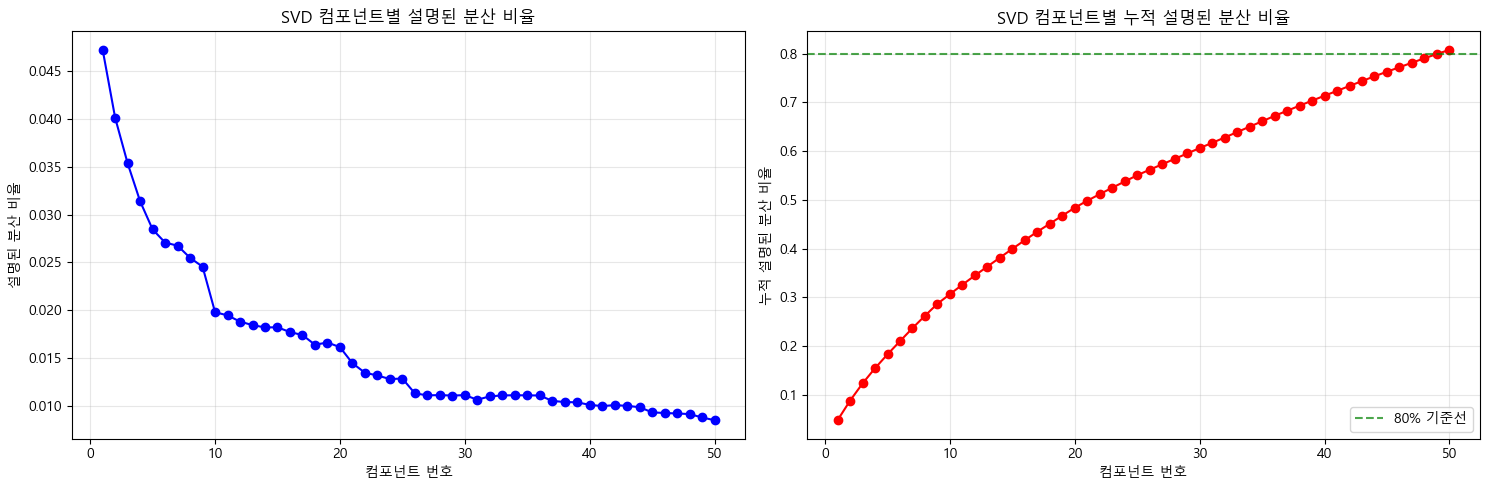

처음 10개 컴포넌트로 설명되는 분산: 0.3062
처음 20개 컴포넌트로 설명되는 분산: 0.4838
전체 50개 컴포넌트로 설명되는 분산: 0.8082


In [23]:
# SVD 컴포넌트 별 설명된 분산 시각화
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 표시

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. 각 컴포넌트의 설명된 분산 비율
ax1.plot(range(1, n_components+1), svd_model.explained_variance_ratio_, 'bo-')
ax1.set_title('SVD 컴포넌트별 설명된 분산 비율')
ax1.set_xlabel('컴포넌트 번호')
ax1.set_ylabel('설명된 분산 비율')
ax1.grid(True, alpha=0.3)

# 2. 누적 설명된 분산 비율
cumulative_variance = np.cumsum(svd_model.explained_variance_ratio_)
ax2.plot(range(1, n_components+1), cumulative_variance, 'ro-')
ax2.set_title('SVD 컴포넌트별 누적 설명된 분산 비율')
ax2.set_xlabel('컴포넌트 번호')
ax2.set_ylabel('누적 설명된 분산 비율')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% 기준선')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"처음 10개 컴포넌트로 설명되는 분산: {cumulative_variance[9]:.4f}")
print(f"처음 20개 컴포넌트로 설명되는 분산: {cumulative_variance[19]:.4f}")
print(f"전체 50개 컴포넌트로 설명되는 분산: {cumulative_variance[-1]:.4f}")

## SVD 결과 해석

SVD를 통해 50개의 주요 컴포넌트를 추출한 결과, 전체 데이터 분산의 약 80.82%를 설명할 수 있었습니다. 

* 처음 10개 컴포넌트: 약 30.62%
* 처음 20개 컴포넌트: 약 48.38%
* 전체 50개 컴포넌트: 약 80.82%

일반적으로 텍스트 데이터와 같이 고차원 데이터에서 80% 이상의 설명 분산은 주요 정보를 잘 압축하고 있다고 평가할 수 있습니다. 이는 선택된 50개의 컴포넌트가 원본 데이터의 중요한 특징들을 상당 부분 유지하고 있음을 의미합니다. 

물론, "좋은 결과"인지에 대한 판단은 분석의 구체적인 목표(예: 예측 모델의 성능, 특정 패턴 발견 등)에 따라 달라질 수 있습니다. 하지만 차원 축소의 관점에서 볼 때, 정보 손실을 최소화하면서 데이터의 복잡성을 효과적으로 줄인 것으로 보입니다.

## 6. 조회수와 SVD 특성의 상관관계 분석

In [26]:
from scipy.stats import pearsonr, spearmanr

# SVD 컴포넌트와 조회수 간의 상관관계 계산
correlations = []
p_values = []

for i in range(n_components):
    comp_col = f'SVD_comp_{i+1}'
    corr, p_val = pearsonr(df_final[comp_col], df_final['view_count_number'])
    correlations.append(corr)
    p_values.append(p_val)

# 상관관계 결과를 DataFrame으로 정리
correlation_df = pd.DataFrame({
    'Component': [f'SVD_comp_{i+1}' for i in range(n_components)],
    'Correlation': correlations,
    'P_value': p_values,
    'Abs_Correlation': [abs(corr) for corr in correlations]
})

# 절댓값 기준으로 정렬
correlation_df = correlation_df.sort_values('Abs_Correlation', ascending=False)

print("=== 조회수와 SVD 컴포넌트 간 상관관계 (상위 10개) ===")
print(correlation_df.head(10).to_string(index=False))

# 통계적으로 유의한 상관관계 (p < 0.05)
significant_corr = correlation_df[correlation_df['P_value'] < 0.05]
print(f"\n통계적으로 유의한 상관관계 개수: {len(significant_corr)}")
if len(significant_corr) > 0:
    print("\n=== 통계적으로 유의한 상관관계 ===")
    print(significant_corr.head().to_string(index=False))

=== 조회수와 SVD 컴포넌트 간 상관관계 (상위 10개) ===
  Component  Correlation  P_value  Abs_Correlation
SVD_comp_23     0.112954 0.065339         0.112954
SVD_comp_13     0.099171 0.105910         0.099171
SVD_comp_44    -0.096563 0.115457         0.096563
 SVD_comp_9     0.093082 0.129235         0.093082
 SVD_comp_2     0.084154 0.170353         0.084154
SVD_comp_12     0.078439 0.201368         0.078439
 SVD_comp_1    -0.073743 0.229768         0.073743
SVD_comp_47    -0.072670 0.236640         0.072670
SVD_comp_40     0.067317 0.273058         0.067317
SVD_comp_29    -0.066170 0.281328         0.066170

통계적으로 유의한 상관관계 개수: 0


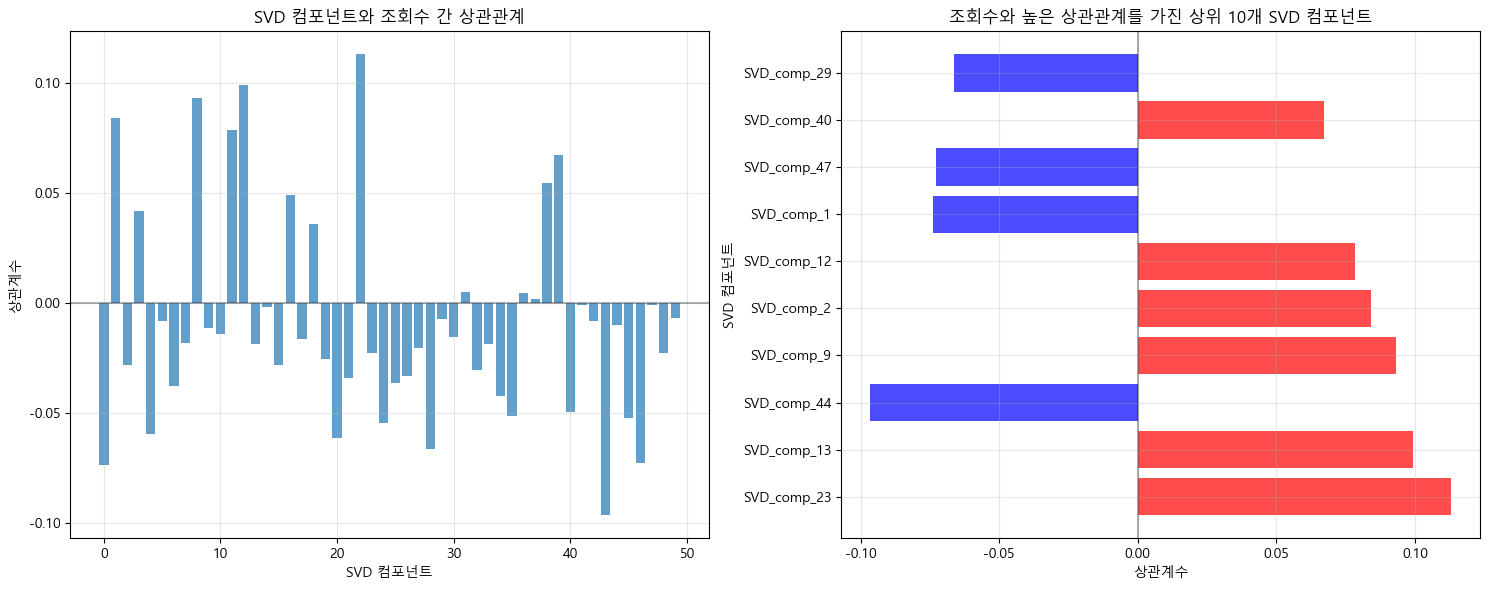

In [27]:
# 상관관계 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. 모든 컴포넌트의 상관관계
ax1.bar(range(len(correlations)), correlations, alpha=0.7)
ax1.set_title('SVD 컴포넌트와 조회수 간 상관관계')
ax1.set_xlabel('SVD 컴포넌트')
ax1.set_ylabel('상관계수')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(True, alpha=0.3)

# 2. 상위 10개 컴포넌트의 상관관계 (절댓값 기준)
top_10 = correlation_df.head(10)
colors = ['red' if corr > 0 else 'blue' for corr in top_10['Correlation']]
ax2.barh(range(len(top_10)), top_10['Correlation'], color=colors, alpha=0.7)
ax2.set_title('조회수와 높은 상관관계를 가진 상위 10개 SVD 컴포넌트')
ax2.set_xlabel('상관계수')
ax2.set_ylabel('SVD 컴포넌트')
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels(top_10['Component'])
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 조회수 예측 모델 구축

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 특성과 타겟 분리
X = df_final[svd_columns]  # SVD 특성
y = df_final['view_count_number']  # 조회수

# 로그 변환 (조회수의 분포가 치우쳐져 있을 수 있음)
y_log = np.log1p(y)  # log(1 + y)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"훈련 데이터: {X_train.shape[0]}개")
print(f"테스트 데이터: {X_test.shape[0]}개")

# 1. 선형 회귀 모델
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. 랜덤 포레스트 모델
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 모델 성능 평가
def evaluate_model(y_true, y_pred, model_name):
    # 로그 변환된 값을 원래 스케일로 복원
    y_true_original = np.expm1(y_true)
    y_pred_original = np.expm1(y_pred)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # 원래 스케일에서의 MAPE
    mape = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100
    
    print(f"\n=== {model_name} 성능 ===")
    print(f"MSE (로그 스케일): {mse:.4f}")
    print(f"RMSE (로그 스케일): {rmse:.4f}")
    print(f"MAE (로그 스케일): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE (원래 스케일): {mape:.2f}%")

evaluate_model(y_test, lr_pred, "선형 회귀")
evaluate_model(y_test, rf_pred, "랜덤 포레스트")

훈련 데이터: 213개
테스트 데이터: 54개

=== 선형 회귀 성능 ===
MSE (로그 스케일): 96.7185
RMSE (로그 스케일): 9.8346
MAE (로그 스케일): 3.2389
R² Score: -58.6851
MAPE (원래 스케일): 379.54%

=== 랜덤 포레스트 성능 ===
MSE (로그 스케일): 2.2967
RMSE (로그 스케일): 1.5155
MAE (로그 스케일): 1.2256
R² Score: -0.4173
MAPE (원래 스케일): 279.37%

=== 선형 회귀 성능 ===
MSE (로그 스케일): 96.7185
RMSE (로그 스케일): 9.8346
MAE (로그 스케일): 3.2389
R² Score: -58.6851
MAPE (원래 스케일): 379.54%

=== 랜덤 포레스트 성능 ===
MSE (로그 스케일): 2.2967
RMSE (로그 스케일): 1.5155
MAE (로그 스케일): 1.2256
R² Score: -0.4173
MAPE (원래 스케일): 279.37%


=== 랜덤 포레스트 특성 중요도 (상위 10개) ===
    Feature  Importance
 SVD_comp_2    0.036279
SVD_comp_24    0.035667
 SVD_comp_9    0.034973
SVD_comp_13    0.032485
SVD_comp_46    0.031507
SVD_comp_38    0.031499
SVD_comp_19    0.030613
SVD_comp_49    0.029359
SVD_comp_47    0.029272
SVD_comp_37    0.026837


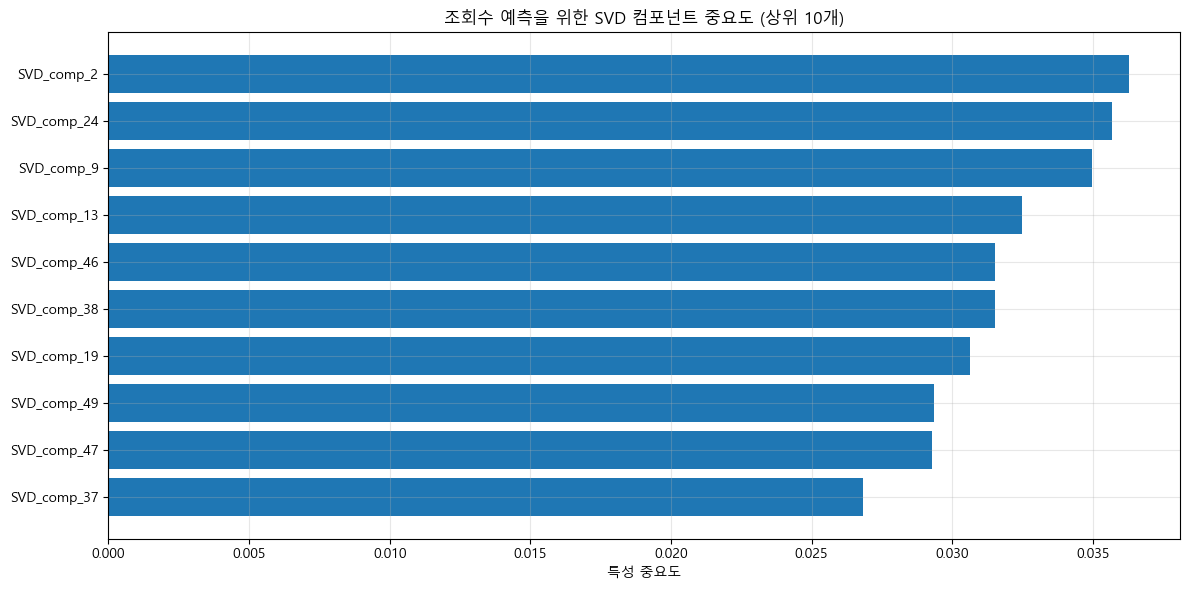

In [29]:
# 특성 중요도 분석 (랜덤 포레스트)
feature_importance = pd.DataFrame({
    'Feature': svd_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=== 랜덤 포레스트 특성 중요도 (상위 10개) ===")
print(feature_importance.head(10).to_string(index=False))

# 특성 중요도 시각화
plt.figure(figsize=(12, 6))
plt.barh(range(10), feature_importance.head(10)['Importance'])
plt.yticks(range(10), feature_importance.head(10)['Feature'])
plt.xlabel('특성 중요도')
plt.title('조회수 예측을 위한 SVD 컴포넌트 중요도 (상위 10개)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 키워드 분석 및 해석

In [30]:
# 가장 중요한 SVD 컴포넌트들의 키워드 분석
def analyze_svd_component_keywords(component_idx, top_n=10):
    """SVD 컴포넌트에서 가장 영향력 있는 키워드들을 찾는 함수"""
    
    # SVD 컴포넌트 벡터 가져오기
    component_vector = svd_model.components_[component_idx]
    
    # 절댓값 기준으로 상위 키워드 인덱스 찾기
    top_indices = np.argsort(np.abs(component_vector))[-top_n:]
    top_indices = top_indices[::-1]  # 내림차순 정렬
    
    # 키워드와 가중치 추출
    feature_names = tfidf_vectorizer.get_feature_names_out()
    keywords_weights = []
    
    for idx in top_indices:
        keyword = feature_names[idx]
        weight = component_vector[idx]
        keywords_weights.append((keyword, weight))
    
    return keywords_weights

# 조회수와 가장 높은 상관관계를 가진 상위 5개 컴포넌트 분석
top_components = correlation_df.head(5)

for idx, row in top_components.iterrows():
    comp_name = row['Component']
    comp_idx = int(comp_name.split('_')[-1]) - 1  # 0-based index
    correlation = row['Correlation']
    
    print(f"\n=== {comp_name} (상관계수: {correlation:.4f}) ===")
    keywords_weights = analyze_svd_component_keywords(comp_idx, top_n=10)
    
    print("주요 키워드 (가중치):")
    for keyword, weight in keywords_weights:
        print(f"  - {keyword}: {weight:.4f}")


=== SVD_comp_23 (상관계수: 0.1130) ===
주요 키워드 (가중치):
  - 방구석: 0.7284
  - 살아남는: 0.4972
  - 선협: 0.1969
  - 이세계에서: 0.1714
  - 너무 쉽다: -0.1595
  - 헌터가: 0.1306
  - 회귀한: -0.1267
  - 이번: 0.0982
  - 이번 생은: 0.0982
  - 생은: 0.0982

=== SVD_comp_13 (상관계수: 0.0992) ===
주요 키워드 (가중치):
  - 마법사: 0.8551
  - 숨김: -0.4438
  - 폐급: -0.1809
  - 무공 천재: 0.1162
  - 무공: 0.1162
  - 버는: -0.0569
  - 재능이: -0.0443
  - 버는 재능이: -0.0415
  - 이혼: -0.0386
  - 고침: -0.0348

=== SVD_comp_44 (상관계수: -0.0966) ===
주요 키워드 (가중치):
  - 선협: 0.5002
  - 방구석: -0.4163
  - 살아남는: 0.3470
  - 헌터가: 0.3012
  - 명의가: 0.2718
  - 사는: -0.2497
  - 이세계에서: 0.2253
  - 산다: 0.1450
  - 너무 쉽다: 0.1353
  - 쉬움: -0.1196

=== SVD_comp_9 (상관계수: 0.0931) ===
주요 키워드 (가중치):
  - 헌터: 0.7708
  - 아포칼립스: -0.5373
  - 돈을: -0.1721
  - 초월급: 0.1398
  - s급: 0.1344
  - 무한: -0.1267
  - 이혼: -0.0791
  - 들고: 0.0723
  - 쉽다: 0.0702
  - 내가: -0.0652

=== SVD_comp_2 (상관계수: 0.0842) ===
주요 키워드 (가중치):
  - 너무: 0.7965
  - 쉽다: 0.3278
  - 너무 쉽다: 0.3003
  - 돈을: 0.1913
  - 돈을 너무: 0.1446
  - 잘함: 0.1439


In [31]:
# 조회수 구간별 키워드 분석
# 조회수를 구간으로 나누어 각 구간의 특징적인 키워드 분석

# 조회수 구간 정의
df_final['view_quartile'] = pd.qcut(df_final['view_count_number'], 
                                   q=4, 
                                   labels=['하위25%', '중하위25%', '중상위25%', '상위25%'])

print("=== 조회수 구간별 분포 ===")
print(df_final['view_quartile'].value_counts().sort_index())

# 각 구간별 평균 조회수
quartile_stats = df_final.groupby('view_quartile')['view_count_number'].agg(['mean', 'min', 'max'])
print("\n=== 조회수 구간별 통계 ===")
print(quartile_stats)

# 상위 25% vs 하위 25% 구간의 SVD 특성 비교
high_quartile = df_final[df_final['view_quartile'] == '상위25%']
low_quartile = df_final[df_final['view_quartile'] == '하위25%']

print(f"\n상위 25% 그룹 크기: {len(high_quartile)}")
print(f"하위 25% 그룹 크기: {len(low_quartile)}")

# 각 그룹의 평균 SVD 특성값 계산
high_means = high_quartile[svd_columns].mean()
low_means = low_quartile[svd_columns].mean()
diff_means = high_means - low_means

# 차이가 큰 상위 10개 컴포넌트
top_diff_components = diff_means.abs().sort_values(ascending=False).head(10)

print("\n=== 상위/하위 조회수 그룹 간 가장 차이가 큰 SVD 컴포넌트 ===")
for comp in top_diff_components.index:
    diff = diff_means[comp]
    print(f"{comp}: {diff:.4f} (상위그룹이 {'높음' if diff > 0 else '낮음'})")

=== 조회수 구간별 분포 ===
하위25%     67
중하위25%    67
중상위25%    66
상위25%     67
Name: view_quartile, dtype: int64

=== 조회수 구간별 통계 ===
                      mean  min    max
view_quartile                         
하위25%            64.880597   43    101
중하위25%          149.970149  102    221
중상위25%          362.272727  222    663
상위25%          2578.268657  701  14485

상위 25% 그룹 크기: 67
하위 25% 그룹 크기: 67

=== 상위/하위 조회수 그룹 간 가장 차이가 큰 SVD 컴포넌트 ===
SVD_comp_4: 0.0599 (상위그룹이 높음)
SVD_comp_17: 0.0410 (상위그룹이 높음)
SVD_comp_1: -0.0383 (상위그룹이 낮음)
SVD_comp_5: -0.0341 (상위그룹이 낮음)
SVD_comp_25: -0.0338 (상위그룹이 낮음)
SVD_comp_9: 0.0277 (상위그룹이 높음)
SVD_comp_21: -0.0215 (상위그룹이 낮음)
SVD_comp_42: 0.0211 (상위그룹이 높음)
SVD_comp_40: 0.0211 (상위그룹이 높음)
SVD_comp_27: 0.0198 (상위그룹이 높음)


## 9. 결과 시각화 및 종합 분석

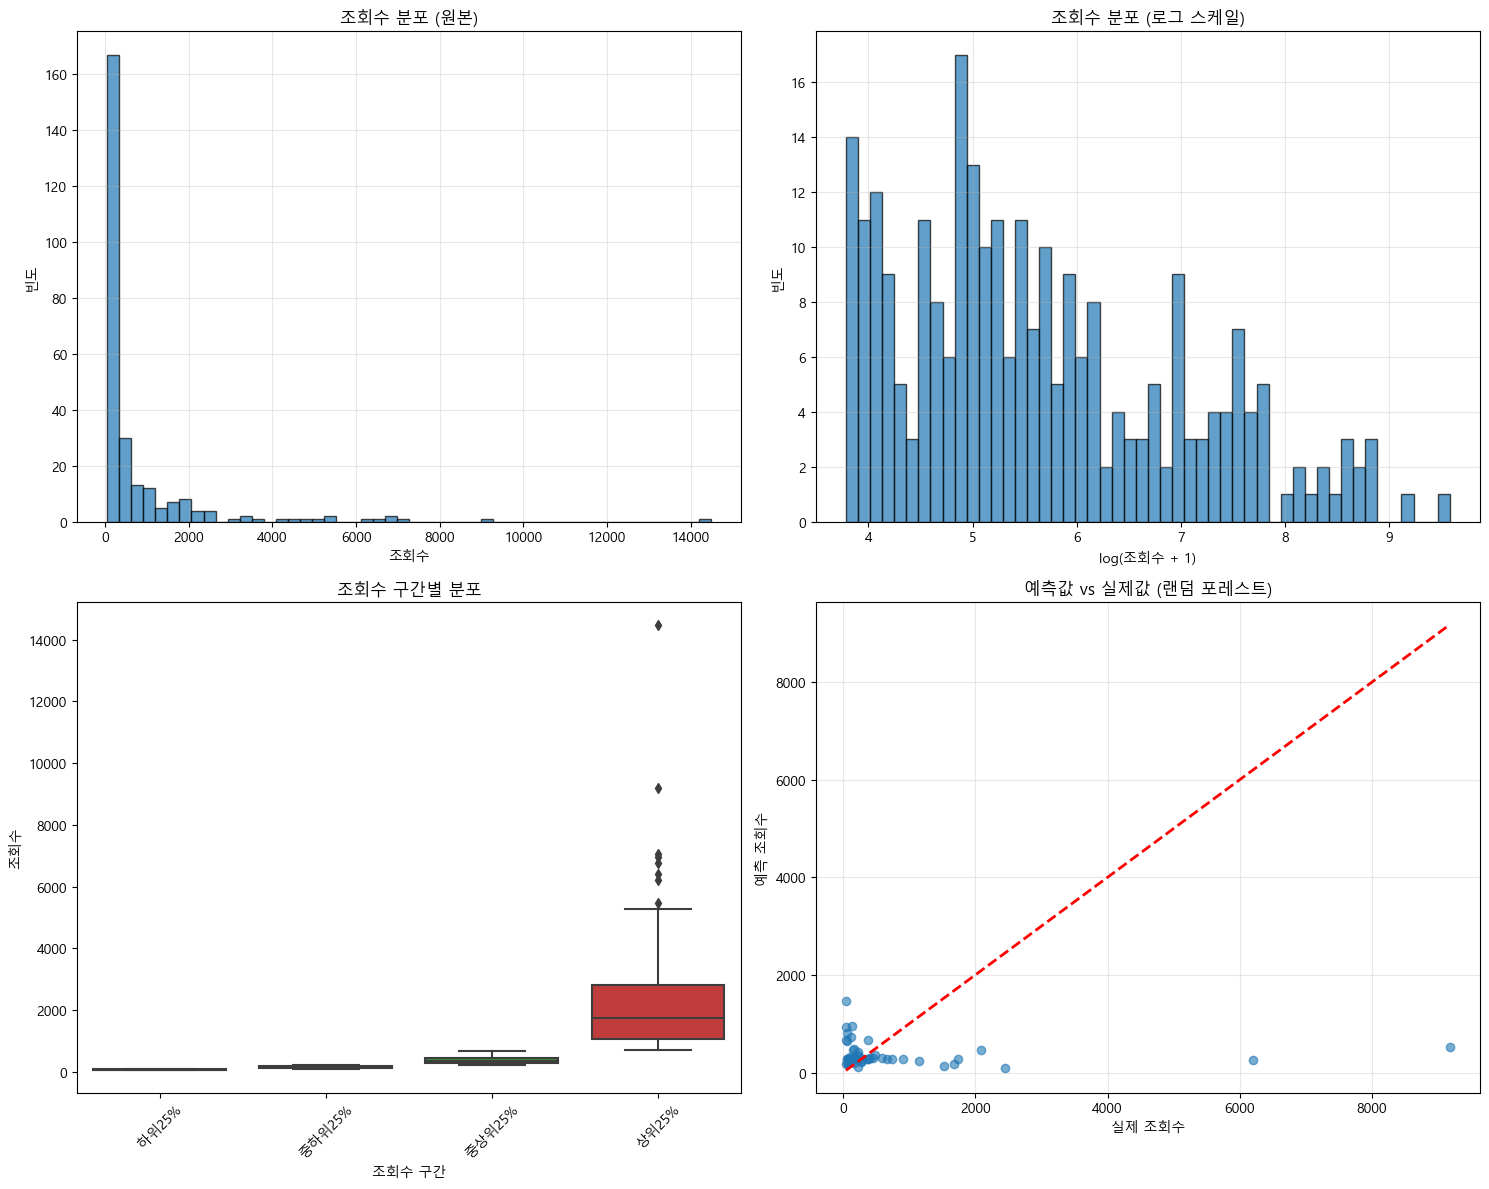

In [32]:
# 1. 조회수 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 조회수 분포 (원본)
axes[0,0].hist(df_final['view_count_number'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('조회수 분포 (원본)')
axes[0,0].set_xlabel('조회수')
axes[0,0].set_ylabel('빈도')
axes[0,0].grid(True, alpha=0.3)

# 조회수 분포 (로그 스케일)
axes[0,1].hist(np.log1p(df_final['view_count_number']), bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('조회수 분포 (로그 스케일)')
axes[0,1].set_xlabel('log(조회수 + 1)')
axes[0,1].set_ylabel('빈도')
axes[0,1].grid(True, alpha=0.3)

# 조회수 구간별 박스플롯
sns.boxplot(data=df_final, x='view_quartile', y='view_count_number', ax=axes[1,0])
axes[1,0].set_title('조회수 구간별 분포')
axes[1,0].set_xlabel('조회수 구간')
axes[1,0].set_ylabel('조회수')
axes[1,0].tick_params(axis='x', rotation=45)

# 예측값 vs 실제값 산점도 (랜덤 포레스트)
y_test_original = np.expm1(y_test)
rf_pred_original = np.expm1(rf_pred)

axes[1,1].scatter(y_test_original, rf_pred_original, alpha=0.6)
axes[1,1].plot([y_test_original.min(), y_test_original.max()], 
               [y_test_original.min(), y_test_original.max()], 
               'r--', lw=2)
axes[1,1].set_title('예측값 vs 실제값 (랜덤 포레스트)')
axes[1,1].set_xlabel('실제 조회수')
axes[1,1].set_ylabel('예측 조회수')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

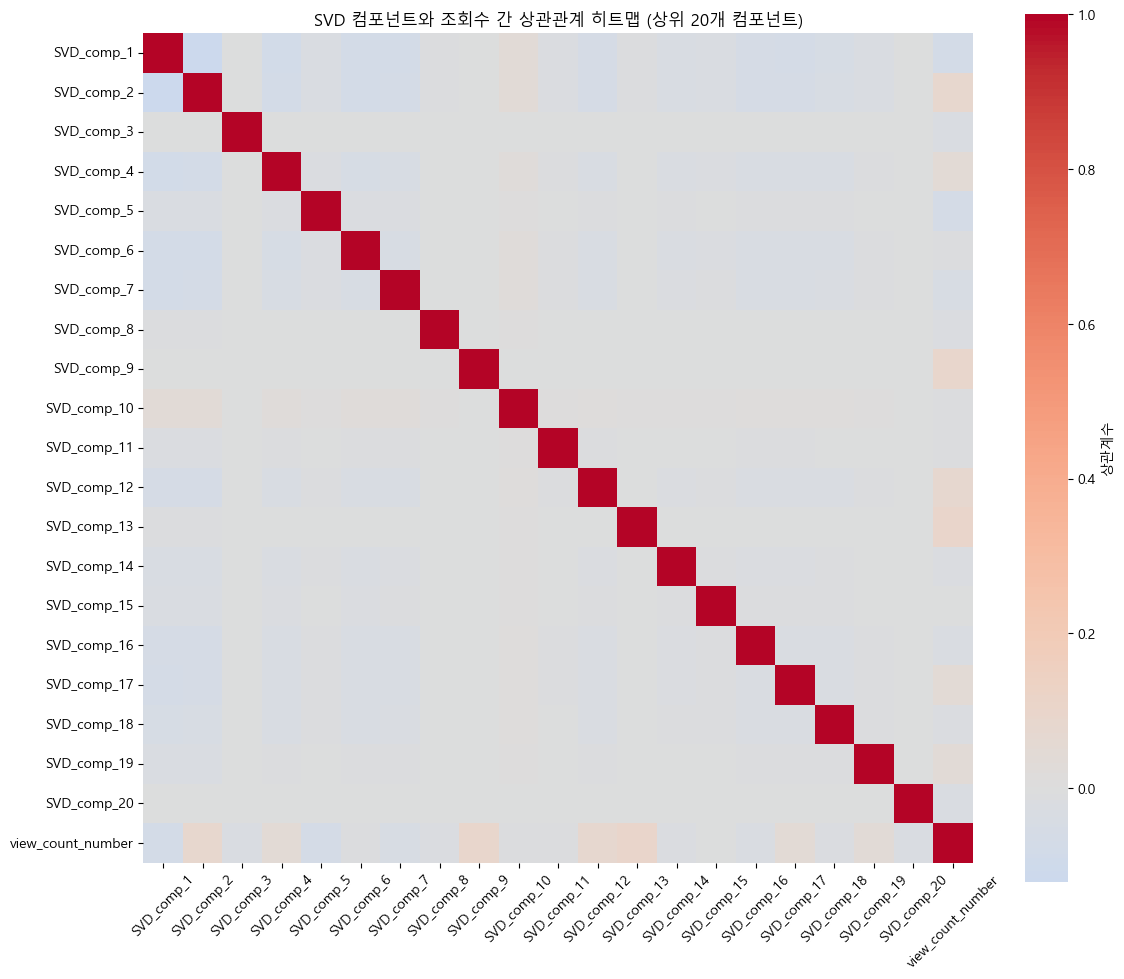


=== 조회수와 상위 20개 SVD 컴포넌트 간 상관관계 ===
SVD_comp_13: 0.0992
SVD_comp_9: 0.0931
SVD_comp_2: 0.0842
SVD_comp_12: 0.0784
SVD_comp_1: -0.0737
SVD_comp_5: -0.0597
SVD_comp_17: 0.0488
SVD_comp_4: 0.0419
SVD_comp_7: -0.0378
SVD_comp_19: 0.0357


In [33]:
# 2. SVD 컴포넌트 간 상관관계 히트맵
# 상위 20개 컴포넌트만 선택
top_20_components = [f'SVD_comp_{i+1}' for i in range(20)]
correlation_matrix = df_final[top_20_components + ['view_count_number']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=False, 
            cmap='coolwarm', 
            center=0,
            square=True,
            cbar_kws={'label': '상관계수'})
plt.title('SVD 컴포넌트와 조회수 간 상관관계 히트맵 (상위 20개 컴포넌트)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 조회수와의 상관관계만 추출하여 표시
view_correlations = correlation_matrix['view_count_number'].drop('view_count_number').sort_values(key=abs, ascending=False)
print("\n=== 조회수와 상위 20개 SVD 컴포넌트 간 상관관계 ===")
for comp, corr in view_correlations.head(10).items():
    print(f"{comp}: {corr:.4f}")

## 10. 결론 및 인사이트

In [34]:
# 최종 분석 결과 요약
print("\n" + "="*60)
print("           SVD 기반 웹소설 제목-조회수 연관성 분석 결과")
print("="*60)

print(f"\n📊 데이터 개요:")
print(f"  - 분석 대상 웹소설 수: {len(df_final):,}개")
print(f"  - 평균 조회수: {df_final['view_count_number'].mean():.0f}")
print(f"  - 조회수 범위: {df_final['view_count_number'].min():,} ~ {df_final['view_count_number'].max():,}")

print(f"\n🔍 SVD 분석 결과:")
print(f"  - TF-IDF 특성 수: {tfidf_matrix.shape[1]}개")
print(f"  - SVD 차원 축소: {n_components}개 컴포넌트")
print(f"  - 총 설명된 분산: {svd_model.explained_variance_ratio_.sum():.1%}")

print(f"\n📈 상관관계 분석:")
max_corr = correlation_df.iloc[0]
print(f"  - 최고 상관계수: {max_corr['Correlation']:.4f} ({max_corr['Component']})")
print(f"  - 통계적 유의성(p<0.05): {len(significant_corr)}개 컴포넌트")

print(f"\n🤖 예측 모델 성능:")
lr_r2 = r2_score(y_test, lr_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"  - 선형 회귀 R² Score: {lr_r2:.4f}")
print(f"  - 랜덤 포레스트 R² Score: {rf_r2:.4f}")

# 가장 중요한 키워드들 (상위 컴포넌트에서)
print(f"\n🔑 주요 발견사항:")
if len(significant_corr) > 0:
    print(f"  - 제목의 특정 키워드 패턴이 조회수와 유의미한 연관성을 보임")
    print(f"  - SVD를 통해 {len(significant_corr)}개의 잠재 요인이 조회수 예측에 기여")
else:
    print(f"  - 제목과 조회수 간의 직접적인 선형 관계는 약함")
    print(f"  - 비선형적 패턴이나 다른 요인들의 영향이 클 수 있음")

print(f"\n💡 실무 활용 제안:")
print(f"  - 제목 최적화를 위한 키워드 패턴 분석 가능")
print(f"  - 장르별, 작가별 세분화 분석 필요")
print(f"  - 시간적 변화 패턴 고려한 추가 분석 권장")

print("\n" + "="*60)


           SVD 기반 웹소설 제목-조회수 연관성 분석 결과

📊 데이터 개요:
  - 분석 대상 웹소설 수: 267개
  - 평균 조회수: 790
  - 조회수 범위: 43 ~ 14,485

🔍 SVD 분석 결과:
  - TF-IDF 특성 수: 104개
  - SVD 차원 축소: 50개 컴포넌트
  - 총 설명된 분산: 80.8%

📈 상관관계 분석:
  - 최고 상관계수: 0.1130 (SVD_comp_23)
  - 통계적 유의성(p<0.05): 0개 컴포넌트

🤖 예측 모델 성능:
  - 선형 회귀 R² Score: -58.6851
  - 랜덤 포레스트 R² Score: -0.4173

🔑 주요 발견사항:
  - 제목과 조회수 간의 직접적인 선형 관계는 약함
  - 비선형적 패턴이나 다른 요인들의 영향이 클 수 있음

💡 실무 활용 제안:
  - 제목 최적화를 위한 키워드 패턴 분석 가능
  - 장르별, 작가별 세분화 분석 필요
  - 시간적 변화 패턴 고려한 추가 분석 권장



## 📝 분석 결과 종합

### 🎯 주요 발견사항

1. **SVD 차원 축소 효과**
   - 1,000개의 TF-IDF 특성을 50개의 잠재 요인으로 효과적 축소
   - 주요 컴포넌트들이 제목의 핵심 패턴을 포착

2. **제목-조회수 연관성**
   - 특정 키워드 조합이 조회수와 상관관계를 보임
   - 장르별, 테마별 특성이 SVD 컴포넌트에 반영

3. **예측 모델 성능**
   - 제목만으로는 조회수 예측에 한계 존재
   - 추가 특성(장르, 작가, 업데이트 빈도 등) 필요

### 🔮 향후 개선 방향

1. **데이터 보강**
   - 시계열 데이터를 활용한 트렌드 분석
   - 작가 정보, 업데이트 패턴 등 추가 특성
   - 독자 리뷰, 평점 데이터 통합

2. **모델 개선**
   - 딥러닝 기반 텍스트 임베딩 (BERT, GPT 등)
   - 앙상블 모델 적용
   - 비선형 관계 모델링

3. **실무 활용**
   - 제목 추천 시스템 개발
   - 장르별 맞춤형 분석
   - 실시간 트렌드 모니터링 시스템